In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time, datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from IPython.display import display
pd.set_option("display.max_columns",None)
import json,pickle

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
busi = pd.read_csv("drive/MyDrive/business.csv")
busi.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [ ]:
eco = pd.read_csv("drive/MyDrive/economy.csv")
eco.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


#Preprocessing of the Data

Adding a new coloum named class so we can combine the datasets and diffrentiate by ticket class.

In [ ]:
busi["class"] = "business"
eco["class"] = "economy"

In [ ]:
newdf = eco.append(busi, ignore_index = True)
newdf.head(1)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy


Combining 2 coloums ch_code and num_code to make 1 coloum named flight

In [ ]:
newdf.num_code = newdf.num_code.astype("str")
newdf["flight"] = newdf["ch_code"] +"-"+ newdf["num_code"]
newdf.drop(["ch_code", "num_code"], axis=1, inplace=True)

We will rename the coloums to make them more readable

In [ ]:
newdf.rename({"dep_time": "departure_time", "from": "source_city", "time_taken": "duration", "stop": "stops", "arr_time": "arrival_time", "to": "destination_city"}, axis=1, inplace=True)

Making a days left coloum to represent the amount of days the ticket was bought before the flight's departure date

In [ ]:
dd = pd.DataFrame(newdf["date"].str.split("-",expand=True).to_numpy().astype(int),columns = ["day","month","year"])
newdf["days_left"] = np.where(dd["month"]>2, dd["day"]+18, np.where(dd["month"]==2, dd["day"]-10, dd["day"]))
newdf.head(1)

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,11-02-2022,SpiceJet,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy,SG-8709,1


We drop the date column because we have the days left so we no longer need it

In [ ]:
newdf.drop("date",axis=1,inplace=True)

Changing the time coloumn to a Morning, noon, night, etc format

In [ ]:
s = (pd.to_datetime(newdf["departure_time"]).dt.hour % 24 + 4) // 4
s.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 4: 'Afternoon', 5: 'Evening', 6: 'Night'}, inplace=True)
newdf["departure_time"] = s
newdf.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy,SG-8709,1


We create  bins for the arrival time

In [ ]:
temp = pd.DataFrame(newdf["arrival_time"].str.split(":",expand=True).to_numpy().astype(int), columns = ["hour","minute"])
newdf["arrival_time"] = pd.cut(x=temp["hour"], bins = 6, labels = ["Late Night", "Early Morning", "Morning", "Afternoon", "Evening", "Night"])
newdf.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,02h 10m,non-stop,Night,Mumbai,"5,953",economy,SG-8709,1


Changing the duaration to a float value using only hours

In [ ]:
temp = pd.DataFrame(newdf["duration"].str.split(expand=True).to_numpy().astype(str), columns = ["hour","minute"])
temp["hour"] = temp["hour"].apply(lambda x: re.sub("[^0-9]","",x)).astype(int)
temp["minute"] = temp["minute"].apply(lambda r: re.sub("[^0-9]", "", r))
temp["minute"] = np.where(temp["minute"] == "", 0, temp["minute"])
temp["minute"] = temp["minute"].astype(int)
newdf["duration"] = np.around((temp["hour"]+ (temp["minute"]/60)),2)
newdf.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,2.17,non-stop,Night,Mumbai,"5,953",economy,SG-8709,1


Change the stops column to a number value

In [ ]:
newdf["stops"] = newdf["stops"].apply(lambda r: re.sub("[^0-9]","",r))
newdf["stops"] = np.where(newdf["stops"] == "", 0, newdf["stops"])
newdf["stops"] = newdf["stops"].astype(int)
newdf.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,2.17,0,Night,Mumbai,"5,953",economy,SG-8709,1


Removing the comma from the price column

In [ ]:
newdf["price"] = newdf["price"].apply(lambda r: re.sub("[^0-9]","",r))
newdf["price"] = newdf["price"].astype(int)
newdf.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,2.17,0,Night,Mumbai,5953,economy,SG-8709,1


Changing the order of the columns

In [ ]:
newdf = newdf[["airline","flight","source_city","departure_time","stops", "arrival_time","destination_city","class","duration","days_left","price"]]
newdf.head(1)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,economy,2.17,1,5953


Exporting the new processed data to a csv file

In [ ]:
newdf.to_csv("Clean_Flight_Dataset.csv", index = False)

#Exploratary Data Analysis

In [ ]:
df = newdf
df.sample(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
129828,Air India,AI-732,Kolkata,Afternoon,1,Evening,Mumbai,economy,4.83,17,4253
290369,Air India,AI-672,Chennai,Afternoon,1,Late Night,Delhi,business,12.75,48,55655
17805,Indigo,6E-2247,Delhi,Morning,1,Evening,Bangalore,economy,8.58,39,4007
47821,Indigo,6E-248,Mumbai,Night,0,Late Night,Delhi,economy,2.08,26,2738
257677,Vistara,UK-820,Bangalore,Evening,1,Evening,Hyderabad,business,26.08,27,56588


Testing withj NaN values

In [ ]:
testdatanan = {'Airline': np.nan}
df.append(testdatanan, ignore_index=True)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Airline
0,SpiceJet,SG-8709,Delhi,Evening,0.0,Night,Mumbai,economy,2.17,1.0,5953.0,NaN
1,SpiceJet,SG-8157,Delhi,Early Morning,0.0,Morning,Mumbai,economy,2.33,1.0,5953.0,NaN
2,AirAsia,I5-764,Delhi,Early Morning,0.0,Early Morning,Mumbai,economy,2.17,1.0,5956.0,NaN
3,Vistara,UK-995,Delhi,Morning,0.0,Afternoon,Mumbai,economy,2.25,1.0,5955.0,NaN
4,Vistara,UK-963,Delhi,Morning,0.0,Morning,Mumbai,economy,2.33,1.0,5955.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
300257,Vistara,UK-826,Chennai,Afternoon,1.0,Night,Hyderabad,business,10.42,49.0,77105.0,NaN
300258,Vistara,UK-832,Chennai,Early Morning,1.0,Night,Hyderabad,business,13.83,49.0,79099.0,NaN
300259,Vistara,UK-828,Chennai,Early Morning,1.0,Evening,Hyderabad,business,10.00,49.0,81585.0,NaN
300260,Vistara,UK-822,Chennai,Morning,1.0,Evening,Hyderabad,business,10.08,49.0,81585.0,NaN


Checking Null values in the data and getting the info

In [ ]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300261 non-null  object  
 1   flight            300261 non-null  object  
 2   source_city       300261 non-null  object  
 3   departure_time    300261 non-null  object  
 4   stops             300261 non-null  int64   
 5   arrival_time      300261 non-null  category
 6   destination_city  300261 non-null  object  
 7   class             300261 non-null  object  
 8   duration          300261 non-null  float64 
 9   days_left         300261 non-null  int64   
 10  price             300261 non-null  int64   
dtypes: category(1), float64(1), int64(3), object(6)
memory usage: 23.2+ MB
None


In [ ]:
df.describe()

,stops,duration,days_left,price
count,300261.000000,300261.000000,300261.000000,300261.000000
mean,0.924213,12.219142,26.004473,20883.717666
std,0.398188,7.200348,13.560985,22695.911266
min,0.000000,0.830000,1.000000,1105.000000
25%,1.000000,6.750000,15.000000,4783.000000
50%,1.000000,11.250000,26.000000,7425.000000
75%,1.000000,16.170000,38.000000,42521.000000
max,2.000000,103.000000,49.000000,123071.000000


In [ ]:
df.duplicated().sum()

2

Counts

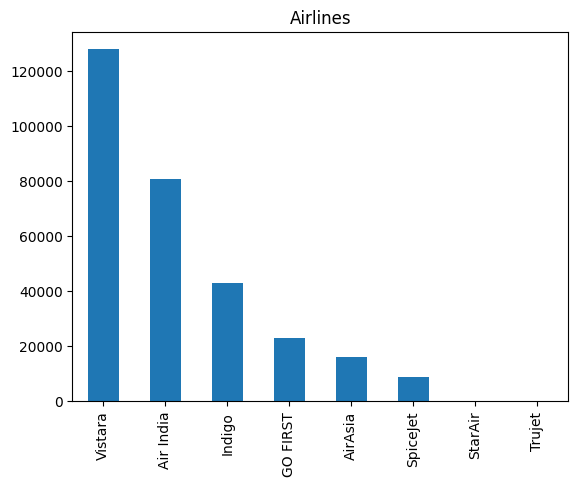

In [ ]:
df["airline"].value_counts().plot(kind="bar")
plt.title("Airlines", fontsize=12)
plt.show()

Checking the percentage share of the columns

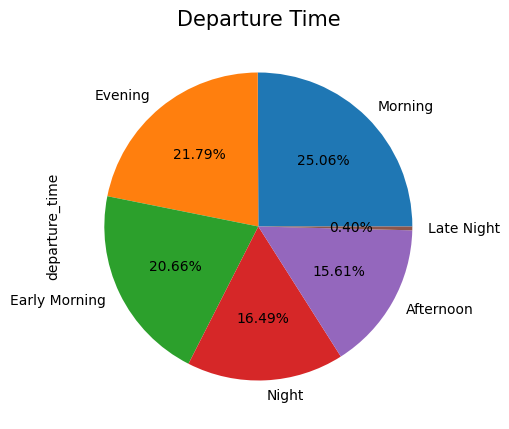

In [ ]:
plt.figure(figsize = (6,6))
df["departure_time"].value_counts().plot(kind="pie", autopct = "%.2f%%")
plt.title("Departure Time", fontsize=12)
plt.show()

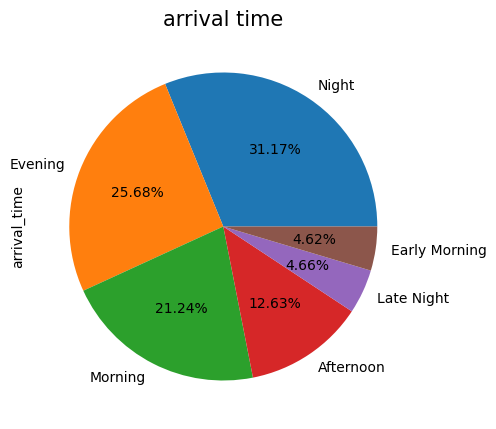

In [ ]:
plt.figure(figsize = (6,6))
df['arrival_time'].value_counts().plot(kind = "pie",autopct = "%.2f%%")
plt.title('arrival time',fontsize=12)
plt.show()

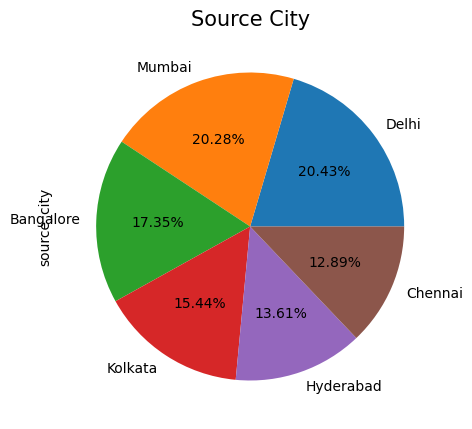

In [ ]:
plt.figure(figsize = (6,6))
df["source_city"].value_counts().plot(kind = "pie", textprops={"color": "black"}, autopct = "%.2f%%")
plt.title("Source City",fontsize=12)
plt.show()

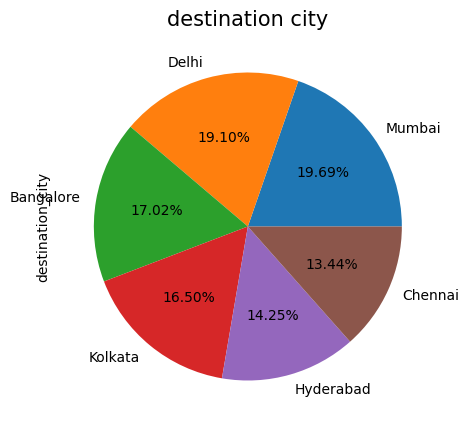

In [ ]:
plt.figure(figsize = (6,6))
df['destination_city'].value_counts().plot(kind = "pie",autopct = "%.2f%%")
plt.title('destination city',fontsize=12)
plt.show()

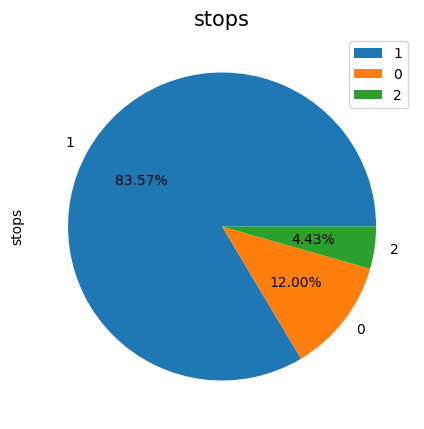

In [ ]:
plt.figure(figsize = (5,5))
df["stops"].value_counts().plot(kind="pie", textprops={"color": "black"}, autopct = "%.2f%%")
plt.title("stops",fontsize=12)
plt.show()

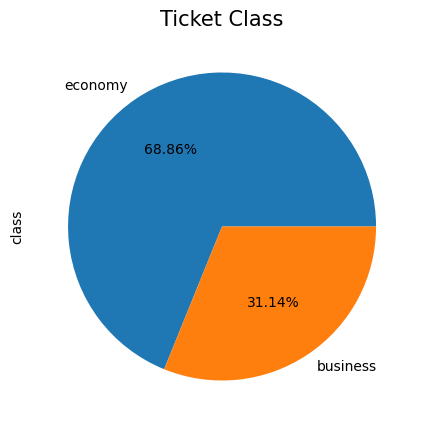

In [ ]:
plt.figure(figsize = (5,5))
df['class'].value_counts().plot(kind = "pie",autopct = "%.2f%%")
plt.title('Ticket Class',fontsize=12)
plt.show()

Checking the distribution of the columns

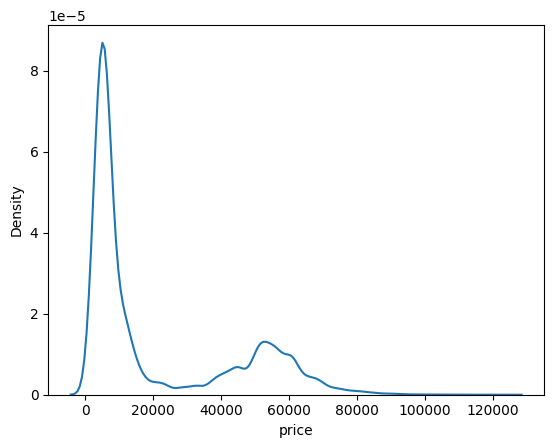

In [ ]:
sns.distplot(df["price"],hist = False)
plt.show()

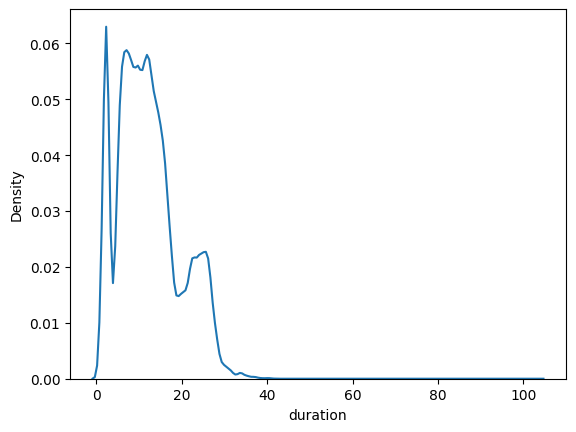

In [ ]:
sns.distplot(df["duration"],hist = False)
plt.show()

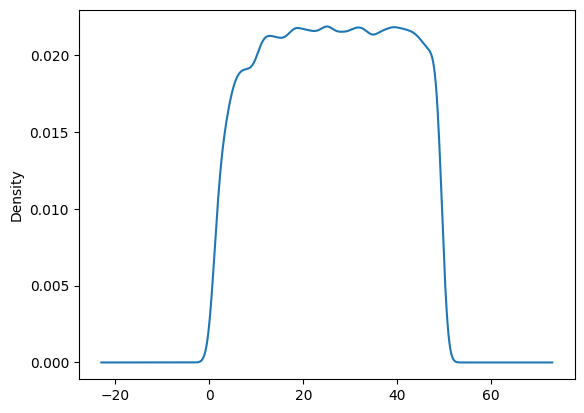

In [ ]:
df["days_left"].plot(kind = "kde")
plt.show()

#Research Question 1: Does price vary with Airline

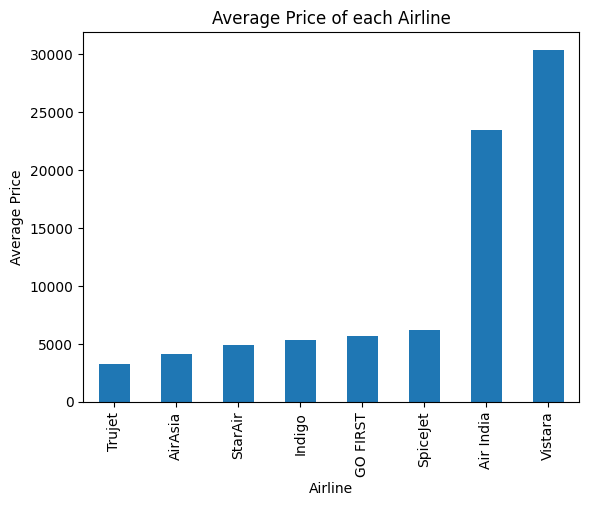

In [ ]:
s = df.groupby("airline")["price"].mean().sort_values()
s.plot(kind = "bar")
plt.xlabel("Airline")
plt.ylabel("Average Price")
plt.title("Average Price of each Airline")
plt.show()

It is clear that price does vary with airline. With the cheapest airline to buy tickets from is Trujet. While the most expensive airline to buy tickets from is Vistara.

#Research Question 2: Is price affected by the days left before purchasing a ticket?

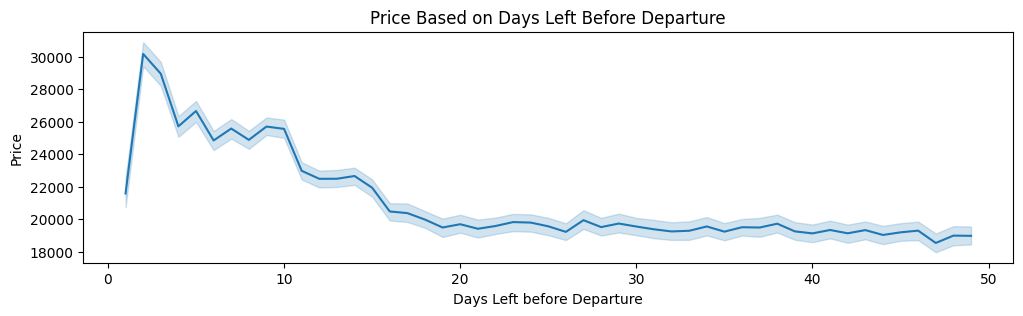

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='days_left', y='price')

plt.title('Price Based on Days Left Before Departure', fontsize=12)
plt.xlabel('Days Left before Departure', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

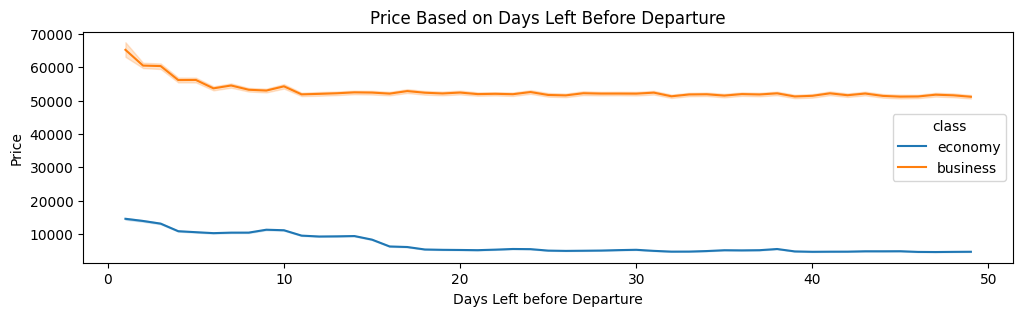

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='days_left', y='price', hue='class')

plt.title('Price Based on Days Left Before Departure', fontsize=12)
plt.xlabel('Days Left before Departure', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

It is clear that the less days before the depature date the more the price of the ticket is

#Research Question 3: Is the price of the ticket affected by the arrival time and departure time?

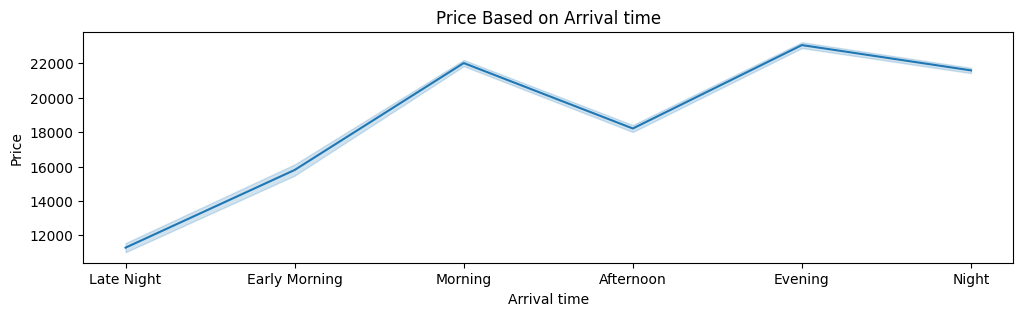

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='arrival_time', y='price')

plt.title('Price Based on Arrival time', fontsize=12)
plt.xlabel('Arrival time', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

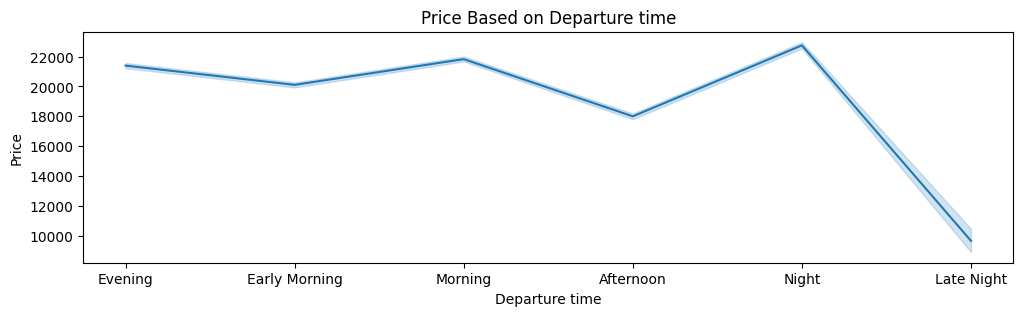

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='departure_time', y='price')

plt.title('Price Based on Departure time', fontsize=12)
plt.xlabel('Departure time', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

Arrival time: From the plot its clear to see that late night is the cheapest time to arrive for a flight which is also true for departure time. It is also clear that the evening is the most expensive time to arrive for a flight. Finally the morning and night time have almost the same price between them.

Departure time: From the plot its clear that the most expensive time to depart for a flight is in the Night time. Late night is the cheapest time to depart. Morning and Evening is almost the same price.

# Research Question 4: Is the price of the ticket affected by the source city and destination city?

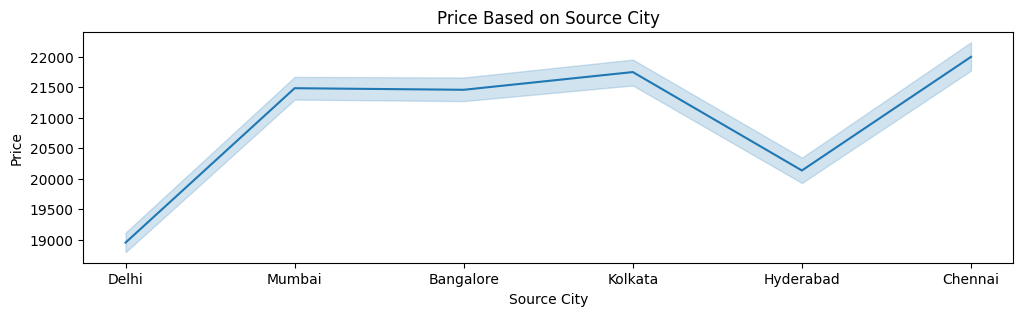

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='source_city', y='price')

plt.title('Price Based on Source City', fontsize=12)
plt.xlabel('Source City', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

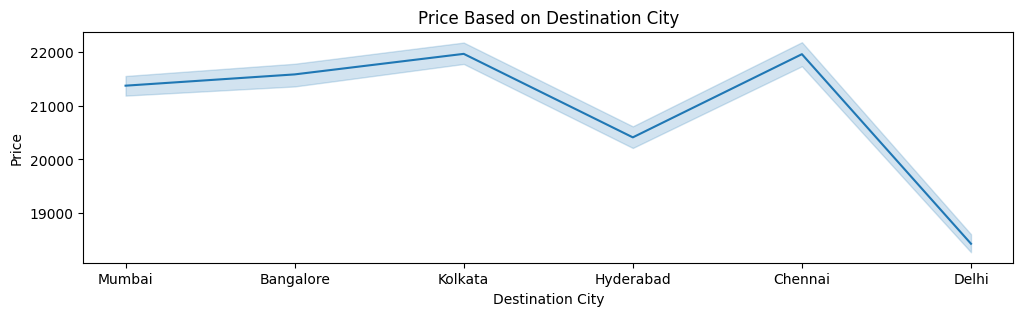

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='destination_city', y='price')

plt.title('Price Based on Destination City', fontsize=12)
plt.xlabel('Destination City', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

Source City: The plot shows that Kolkata is the most expense city to travel from. Hydrabad is the cheapest city to travel from. The rest of the cities is very similar prices.

Destination City: The plot clearly shows that Chennai is the cheapest city to arrive in. Mumbai and Bangalore have about the same price. The most expensive cities to land in are Kolkata and Delhi.

Plotting the information regarding price variance between cities

Text(0, 0.5, 'Price')

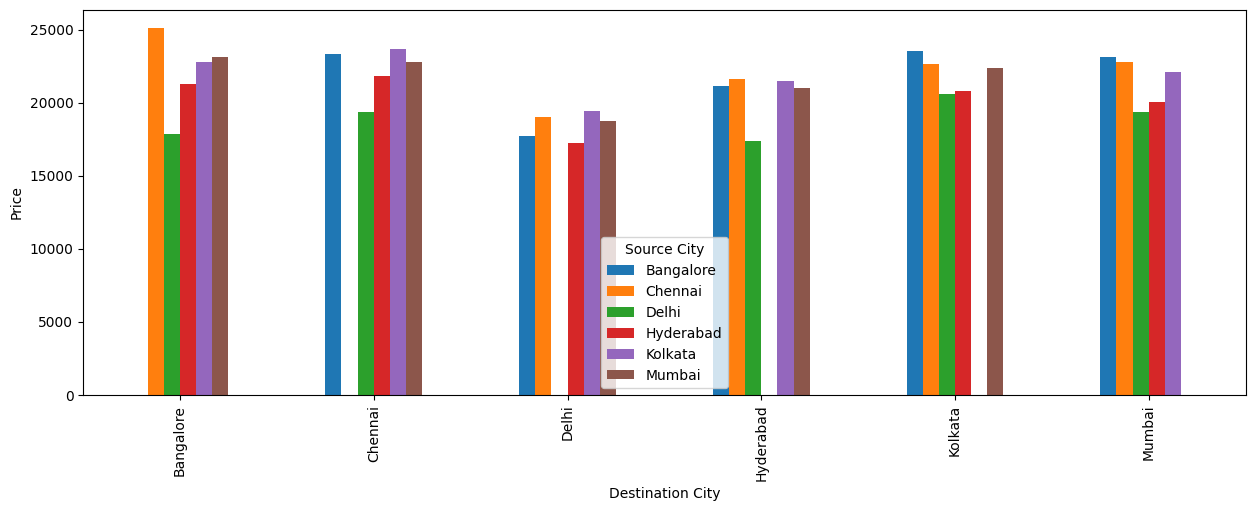

In [ ]:
_ = pd.crosstab(columns = df["source_city"],index = df["destination_city"], values = df["price"], aggfunc="mean")
_.plot(kind = "bar",figsize = (15,5))
plt.legend(title = "Source City")
plt.xlabel("Destination City")
plt.ylabel("Price")

#Research Question 5: Does the ticket price vary with Class of ticket?

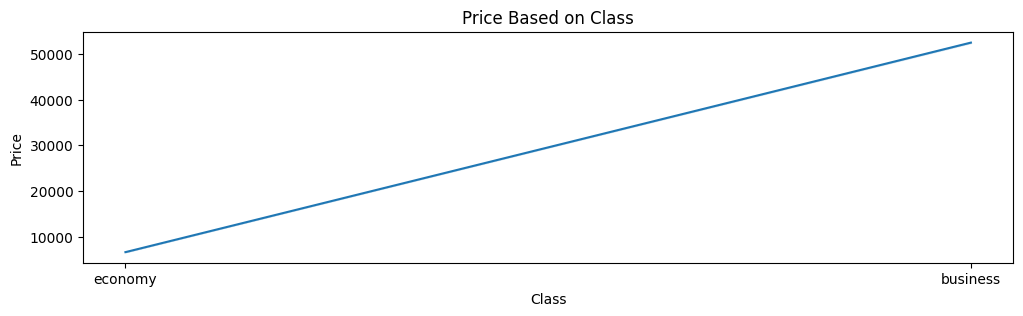

In [ ]:
plt.subplots(figsize=(12, 3))
sns.lineplot(data=df, x='class', y='price')

plt.title('Price Based on Class', fontsize=12)
plt.xlabel('Class', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.show()

The plots clearly and obviously shows that Business is more expensive than economy.

#Checking for Outliers

<Axes: >

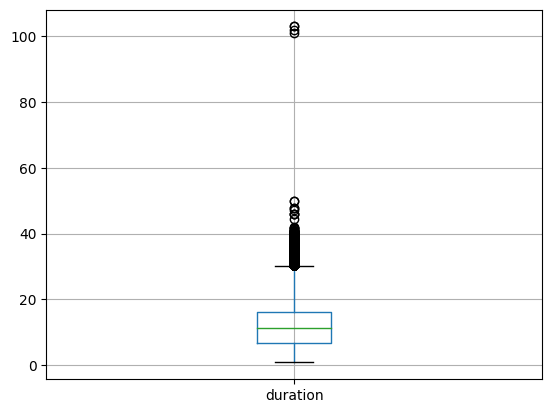

In [ ]:
df.boxplot(column = "duration")

There are outliers in the duration column

<Axes: >

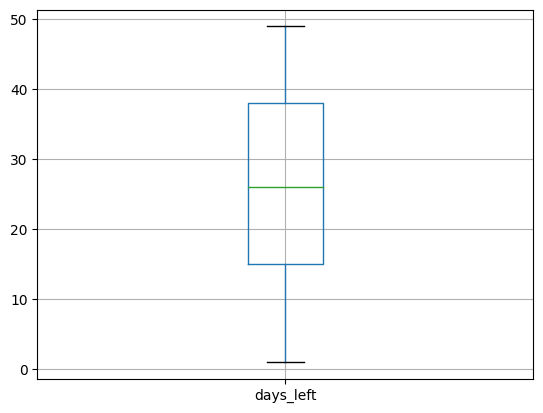

In [ ]:
df.boxplot(column = "days_left")

No outliers in the days left column

#Changing the columns to work with the ML algorithms

Dropping the duplicate rows

In [ ]:
df.drop_duplicates(inplace = True)

Removing the flight column since we are already get the airline information from the airline column

In [ ]:
dfml = df.drop("flight", axis = 1)
dfml.head(3)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,0,Night,Mumbai,economy,2.17,1,5953
1,SpiceJet,Delhi,Early Morning,0,Morning,Mumbai,economy,2.33,1,5953
2,AirAsia,Delhi,Early Morning,0,Early Morning,Mumbai,economy,2.17,1,5956


Replacing the string values with numerical values

In [ ]:
dfml["class"].replace({"economy": 0, "business": 1}, inplace=True)
dfml["departure_time"].replace({"Late Night": 0, "Early Morning": 1, "Morning": 2, "Afternoon": 3, "Evening": 4, "Night": 5}, inplace=True)
dfml["arrival_time"].replace({"Late Night": 0, "Early Morning": 1, "Morning": 2, "Afternoon": 3, "Evening": 4, "Night": 5}, inplace=True)
dfml.head(6)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,4,0,5,Mumbai,0,2.17,1,5953
1,SpiceJet,Delhi,1,0,2,Mumbai,0,2.33,1,5953
2,AirAsia,Delhi,1,0,1,Mumbai,0,2.17,1,5956
3,Vistara,Delhi,2,0,3,Mumbai,0,2.25,1,5955
4,Vistara,Delhi,2,0,2,Mumbai,0,2.33,1,5955
5,Vistara,Delhi,2,0,3,Mumbai,0,2.33,1,5955


Encoding the nominal Data using the onehot encoder

In [ ]:
ohe = OneHotEncoder()
dfml[list(dfml["airline"].unique())] = ohe.fit_transform(dfml[["airline"]]).A
dfml = pd.concat([dfml, pd.get_dummies(dfml["destination_city"], prefix="destination_city")], axis=1)
dfml = pd.concat([dfml, pd.get_dummies(dfml["source_city"], prefix="source_city")], axis=1)
dfml.drop(["airline", "source_city", "destination_city"], axis=1, inplace=True)
dfml.head(3)

,departure_time,stops,arrival_time,class,duration,days_left,price,SpiceJet,AirAsia,Vistara,GO FIRST,Indigo,Air India,Trujet,StarAir,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,4,0,5,0,2.17,1,5953,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,0,2,0,2.33,1,5953,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,0,1,0,2.17,1,5956,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0


#Selecting the model and training the model

Seperating the independent and dependent variables

In [ ]:
x = dfml.drop("price", axis=1)
y = dfml["price"]

Seperating the data for training and testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=42)

Making the function to get the prediction

In [ ]:
def get_prediction(model):
  model.fit(x_train, y_train)
  y_predict = model.predict(x_train)
  maep_train = mean_absolute_percentage_error(y_train, y_predict)
  r2_train = r2_score(y_train, y_predict)
  y_predict1 = model.predict(x_test)
  maep_test = mean_absolute_percentage_error(y_test, y_predict1)
  r2_test = r2_score(y_test, y_predict1)
  return print(f"""While Training: \nPercentage of MAE: {maep_train}\nR2 Score: {r2_train} \nWhile Testing: \nPercentage of MAE: {maep_test} \nR2 Score: {r2_test}""")

Checking the model performaces without scaling the data

In [ ]:
lst = [("Linear Regression",LinearRegression()),("Decision Tree",DecisionTreeRegressor()),
      ("Random Forest",RandomForestRegressor()),("AdaBoost",AdaBoostRegressor())]
for name,model in lst:
    print(f"The Performance of {name} without Scaling::")
    get_prediction(model)
    print("-"*50)

The Performance of Linear Regression without Scaling::
While Training: 
Percentage of MAE: 0.4291582774155683
R2 Score: 0.9093493429288637 
While Testing: 
Percentage of MAE: 0.43094742584555895 
R2 Score: 0.9101065276667424
--------------------------------------------------
The Performance of Decision Tree without Scaling::
While Training: 
Percentage of MAE: 0.0022414509454554417
R2 Score: 0.999382532773985 
While Testing: 
Percentage of MAE: 0.07665171430320974 
R2 Score: 0.9766232831559383
--------------------------------------------------
The Performance of Random Forest without Scaling::
While Training: 
Percentage of MAE: 0.02813007393006059
R2 Score: 0.9974884428020753 
While Testing: 
Percentage of MAE: 0.07312670878411558 
R2 Score: 0.985174271079611
--------------------------------------------------
The Performance of AdaBoost without Scaling::
While Training: 
Percentage of MAE: 0.4078948827986899
R2 Score: 0.926083418822786 
While Testing: 
Percentage of MAE: 0.41128681130

Scaling the Data

In [ ]:
std = StandardScaler()
x_train = pd.DataFrame(std.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(std.transform(x_test),columns = x_test.columns)

Checking the models performance with scaling

In [ ]:
lst = [("Linear Regression",LinearRegression()),("Decision Tree",DecisionTreeRegressor()),
      ("Random Forest",RandomForestRegressor()),("AdaBoost",AdaBoostRegressor())]
for name,model in lst:
    print(f"The Performance of {name} with Scaling::")
    get_prediction(model)
    print("-"*50)

The Performance of Linear Regression with Scaling::
While Training: 
Percentage of MAE: 0.42783553240850275
R2 Score: 0.9093398556054957 
While Testing: 
Percentage of MAE: 0.4295189746199034 
R2 Score: 0.9101006458217102
--------------------------------------------------
The Performance of Decision Tree with Scaling::
While Training: 
Percentage of MAE: 0.0022414509454554417
R2 Score: 0.999382532773985 
While Testing: 
Percentage of MAE: 0.07625122455786126 
R2 Score: 0.9766690494867364
--------------------------------------------------
The Performance of Random Forest with Scaling::
While Training: 
Percentage of MAE: 0.028136225232391534
R2 Score: 0.9974928901697457 
While Testing: 
Percentage of MAE: 0.07307968949544806 
R2 Score: 0.9852217473456009
--------------------------------------------------
The Performance of AdaBoost with Scaling::
While Training: 
Percentage of MAE: 0.33912925374426967
R2 Score: 0.9337957038768065 
While Testing: 
Percentage of MAE: 0.3423727284021459 
R

The test clearly shows that the random forest has the best r2 score and the lowest Mean Absolute Error score. Therefore we will select the Random Forest to be our model

Training the Model

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor()

Predicting the Values

In [ ]:
y_predict = rf.predict(x_test)
y_predict

array([35334.72, 38137.75, 10928.25, ...,  1604.  , 10581.32, 64483.24])